In [2]:
from cvxpy import *
import numpy as np
import networkx as nx
import scipy.linalg as sla
import mosek
import matplotlib.pyplot as plt
%precision %.2f
np.set_printoptions(precision=2)

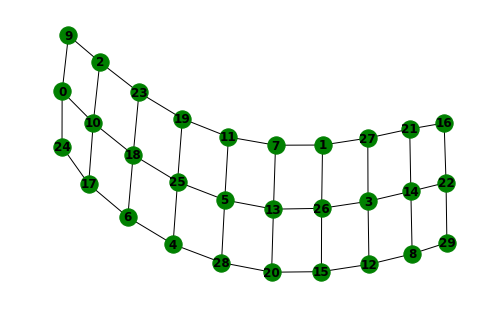

In [32]:
# networks Set up 
# Create Graph Object
G = nx.grid_graph([3,10])
e = G.number_of_edges();
v = G.number_of_nodes();


# --------Source Vector set up ----------------#
sourceNode = 9; 
sinkNode = 29;
sourceVec = np.zeros((v));
sourceVec[sourceNode] = -1;
sourceVec[sinkNode] = 1;

#---------Draw Graph---------#
G = nx.convert_node_labels_to_integers(G)
nx.draw(G, node_color='g', edge_color='k', with_labels=True, font_weight='bold')



In [51]:
ActionNum = 5;
#------------latency function-------------------#
# Currently only state dependent
def Reward(x): 
    A = np.diag(np.linspace(1,v,v))
    b = np.linspace(v-1,0, v) 
    RewardMat= np.array([A.dot(x) + b,]*ActionNum).T
    return RewardMat;
#-------------probability transition parameters----------------------#
oneV = np.ones((v))
def Pmat(action):
    return (1. - action)/v* np.outer(oneV, oneV) + (action - (1. - action)/v)*np.diag(oneV);
# Pmat(3)

In [12]:
# Generate routes matrix
def RouteGen(graph, edgeSet, sourceN, sinkN):
    routes =  list(nx.all_simple_paths(graph, source=sourceN, target=sinkN));
    RouteMat = np.zeros((graph.number_of_edges(), len(routes)));
    for route in range(0,len(routes)):
        curRoute = routes[route];#Route is in nodes
        #Look for the index of corresponding edge
        for edge in range(0,len(curRoute)-1):
            #Unpack edge
            start= curRoute[edge]; end = curRoute[edge+1];
            edgeInd = edgeSet.index((start,end)); #find the edge index in list
            RouteMat[edgeInd,route]= 1;
    return RouteMat;
RouteGen(G,edges,sourceNode,sinkNode)

array([], shape=(41L, 0L), dtype=float64)

In [1]:
# Construct the problem.
#----------------WARDROP EQUILIBRIUM--------------------
x = Variable(e); 
z = Variable(r);
warPot =  b*x + quad_form(x,A)*0.5;
warObj = Minimize(warPot);
warConstraints = [0 <= z, 
                  RouteMat*z == x,
                  sum(z) == mass]
wardrop = Problem(warObj, warConstraints)
warRes = wardrop.solve(solver=MOSEK)